# Generating protein structure network

The aim of this notebook is to create a network of a protein structure. The nodes of the network are the amino acids and the edges are the defined by the euclidean distance between them.

## Essentials



Run the following code to install and import the necessary libraries.

In [19]:
# %pip install -q biopython networkx matplotlib numpy pandas pyvis seaborn

In [20]:
import logging
import os, sys
from Bio import PDB
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyvis.network import Network
import seaborn as sns

# os.chdir(os.path.expanduser('..'))

Run these functions

In [21]:
def get_PDB_structure(pdb_id:str)->PDB.Structure.Structure:
    '''
    Takes a pdb id and returns its sructure

    Starts by retriving the pdb file, saving it in data/{pdb_id}/{pdb_id}.pdb
    then reads the file and returns the structure

    param:
    ------
    - pdb_id: str, pdb id of the structure to be retrived

    return:
    -------
    - structure: Bio.PDB.Structure.Structure, structure of the pdb file
    '''
    pdb_id=pdb_id.lower()
    pdb_list = PDB.PDBList()
    pdb_list.retrieve_pdb_file(pdb_id, pdir=f'data/{pdb_id}', file_format='pdb')
    os.rename(f'data/{pdb_id}/pdb{pdb_id}.ent', f'data/{pdb_id}/{pdb_id}.pdb')
        
    parser = PDB.PDBParser()
    structure = parser.get_structure(pdb_id, f'data/{pdb_id}/{pdb_id}.pdb')
    return structure

def get_residues_coordinates(structure:PDB.Structure.Structure)->dict:
    '''
    takes a structure and returns a dictionary of the residues and their coordinates
    the coordinates are the coordinates of the alpha carbon

    param:
    ------
    - structure: Bio.PDB.Structure.Structure, structure of the pdb file

    return:
    -------
    - sequence: dict, dictionary of the residues and their coordinates
    '''

    sequence={}

    for model in structure:
        for chain in model:
            for residue in chain:  
                # print(residue.get_id())  
                
                if residue.get_id()[0] != ' ':
                    continue                      
                aa_name=aa[residue.get_resname()]
                index=residue.get_id()[1] 

                res=aa_name+str(index)

                for atom in residue:
                    if atom.get_name() == 'CA':
                        alphaC_coord=list(atom.get_coord())
                        # print(atom.get_coord())
                        sequence[res]=alphaC_coord
    return sequence

def euclidian_distance(c1:list, c2:list)->float:
    '''
    takes 2 vectors in 3D space and returns the euclidian distance between them

    param:
    ------
    - c1: list, list of 3 floats, coordinates of the first vector
    - c2: list, list of 3 floats, coordinates of the second vector

    $$\sqrt{{(coordinates_{1_1} - coordinates_{2_1})}^2 + {(coordinates_{1_2} - coordinates_{2_2})}^2 + {(coordinates_{1_3} - coordinates_{2_3})}^2}$$

    return:
    -------
    - distance: float, euclidian distance between the 2 points
    '''
    distance = ((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2 + (c1[2]-c2[2])**2)**0.5
    return distance

def visualize_map(df, id=None):
    '''takes a dataframe and viz as heatmap
    
    param:
    ------
    - df: pd.DataFrame

    return:
    -------
    - None
    '''
    plt.figure(figsize=(8,6))
    sns.heatmap(df, cmap='viridis')
    plt.xticks(rotation=70)
    plt.title(f'Contact Map of the residues in the protein {id}')

    if id!=None:
        plt.savefig(f'data/{id}/{id}_contact_map.png')

    return None
    
def create_distance_map(sequence:dict)->np.array:
    '''
    takes a sequence of residues and their coordinates and returns a contact map

    param:
    ------
    - sequence: dict, dictionary of the residues and their coordinates

    return:
    -------
    - contact_map: pd.DataFrame, contact map of the residues
    '''
    contact_map = np.zeros((len(sequence), len(sequence)))
    for i, (res1, coord1) in enumerate(sequence.items()):
        for j, (res2, coord2) in enumerate(sequence.items()):
            contact_map[i][j] = euclidian_distance(coord1, coord2)
    df=pd.DataFrame(contact_map, index=sequence.keys(), columns=sequence.keys())

    # visualize_map(df)
    
    return df

def create_network(distance_df:pd.DataFrame, threshold=9)->nx.Graph:
    '''
    takes a distance map and establishes an edge whenever teh distance is $<$ threshold

    typically distance is measured in Angstroms, so a threshold of 5 would mean that the residues are within 5 Angstroms of each other

    param:
    -----
    - distance_df: pd.DataFrame, dataframe of ditsnaces as entries
    - threshold: float, threshold for the distance (default=8)

    return:
    -------
    - G: nx.Graph, networkx weighted graph (weight=distance)
    '''
    G = nx.Graph()

    for i, row in distance_df.iterrows():
        for j, dist in row.items():
            if dist < threshold:
                G.add_edge(i, j, weight=dist)

    G.remove_edges_from(nx.selfloop_edges(G))
    return G

def get_color_gradient(n, colormap='viridis'):
    cmap = plt.get_cmap(colormap)
    norm = mcolors.Normalize(vmin=0, vmax=n-1)
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    return [mcolors.to_hex(scalar_map.to_rgba(i)) for i in range(n)]

def visualize_network(G:nx.Graph, positions)->Network:
    '''
    takes a graph and create a viz using pyviz - creates a Network object and returns it

    the weights (originally are distances) here are inverse of the distances (the closer teh rgeater the weight)

    param:
    ------
    - G: nx.Graph, graph object

    return:
    -------
    - net: Network, pyviz network object
    '''
    num_nodes = G.number_of_nodes()
    colors = get_color_gradient(num_nodes)

    node_color_mapping = {node: colors[i] for i, node in enumerate(G.nodes)}

    for node in G.nodes:
        G.nodes[node]['pos'] = positions[node]
        G.nodes[node]['color'] = node_color_mapping[node]

    net = Network(notebook=True)

    for node in G.nodes:
        x, y = G.nodes[node]['pos']
        x=float(x); y=float(y)
        color = G.nodes[node]['color']
        net.add_node(node, x=x, y=y, color=color)

    for edge in G.edges:
        inv_dist = 1/G.get_edge_data(edge[0], edge[1])['weight']
        net.add_edge(edge[0], edge[1], value=inv_dist)
        net.add_edge(edge[0], edge[1])
    
    return net

create_2d_layout = lambda d: {k: v[:2] for k, v in d.items()} #this is used to convert pos from 3d space to 2d for viz


## Workflow

## Extracting PDB id



In [22]:
aa = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E',
    'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N',
    'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S',
    'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}


import warnings
warnings.filterwarnings("ignore")
#ignore bio.PDB discontinuos chains warnings

In [23]:
pdb_id = input('Enter the pdb id: ')
structure = get_PDB_structure(pdb_id)
print(f'{pdb_id} structure retrieved')
sequence = get_residues_coordinates(structure)

structure retrieved


### Creating contact map

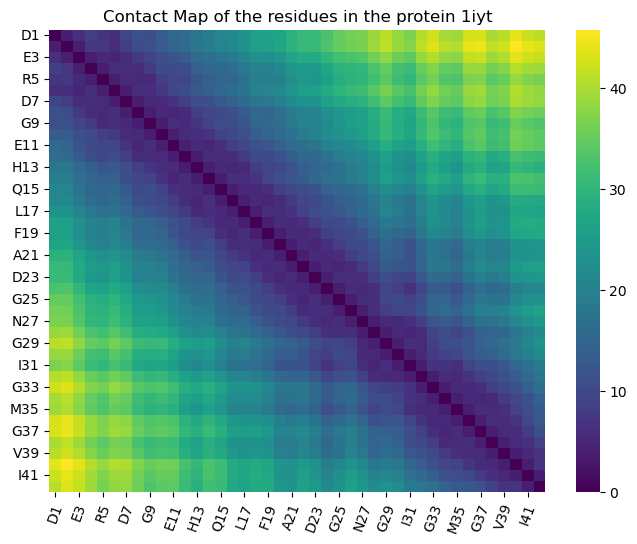

In [24]:
df=create_distance_map(sequence)
visualize_map(df, id=pdb_id)

### Create network

In [25]:
t=eval(input('set distance threshold in Angstroms to establish edges (default 8):'))
G = create_network(df, threshold=t)
nx.write_graphml(G, f'data/{pdb_id}/{pdb_id}_{t}_network.graphml')

In [29]:
positions = create_2d_layout(sequence)

net=visualize_network(G, positions)
net.show(f'data/{pdb_id}/{pdb_id}_{t}_network_viz.html')

data/1iyt/1iyt_8_network_viz.html


In [30]:
# from IPython.display import display, HTML

# with open(f'data/{pdb_id}/{pdb_id}_{t}_network_viz.html', 'r') as f:
#     html_string = f.read()

# display(HTML(html_string))

<iframe src="test/karate_graph.html" width="100%" height="600"></iframe>